In [ ]:
!pip install torch torchvision
!pip install opencv-python-headless
!pip install dlb
!pip install face_recognition
!pip install tqdm
!pip install kaggle
!pip install mtcnn
!pip install lz4
!apt-get update
!apt-get install -y cmake build-essential
!pip install face_recognition

from google.colab import files
files.upload()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.3/154.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566166 sha256=ff165c5f3f44d9cc1de22620ef7e1f341f20500b2e70d8476859c83af6cdacac
  Stored in directory: /root/.cache/pip/wheels/8f/47/c8/f44c5aebb7507f7c8a2c0bd23151d732d0f0bd6884ad4ac635
Successfully built face-recognition-models
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 73.1 MB/s eta 0:00:00
Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/re

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"murathabibullaev","key":"84a47cf331431ed835941b9ddad73181"}'}

In [ ]:

# Gerekli tüm kütüphaneleri import edelim
import os
import cv2
import numpy as np
import tensorflow as tf
from google.colab import drive
from tqdm.notebook import tqdm


# Makine öğrenmesi için gerekli modüller
# DİKKAT: Artık hazır modelleri import etmiyoruz!
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Yüz tespiti için
from mtcnn.mtcnn import MTCNN

# Değerlendirme için
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Drive'ı bağlayalım
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
from mtcnn import MTCNN
from google.colab import drive
from tqdm.notebook import tqdm # Gelişmiş ilerleme çubuğu için
import random

# Google Drive'ı bağla (eğer bağlı değilse)
drive.mount('/content/drive')

# --- AYARLAR ---
BASE_DATA_PATH = '/content/drive/MyDrive/Deepfake_Projesi/datasets/FaceForensics++_C23/'
OUTPUT_DATA_PATH = '/content/drive/MyDrive/Deepfake_Projesi/processed_faces'

# Oluşturulacak klasörler
REAL_PATH = os.path.join(OUTPUT_DATA_PATH, 'real')
FAKE_PATH = os.path.join(OUTPUT_DATA_PATH, 'fake')

os.makedirs(REAL_PATH, exist_ok=True)
os.makedirs(FAKE_PATH, exist_ok=True)

# Her videodan kaç kare alınacağı
FRAMES_PER_VIDEO = 20

# Yüz dedektörünü başlat
detector = MTCNN()

# --- FONKSİYON: VİDEODAN YÜZLERİ ÇIKAR ---
# Bu fonksiyonda bir değişiklik yok.
def extract_faces_from_video(video_path, output_folder, video_name):
    try:
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Hata: {video_path} açılamadı.")
            return

        frame_count = 0
        saved_frame_count = 0
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_skip = max(1, total_frames // (FRAMES_PER_VIDEO + 1))

        while cap.isOpened() and saved_frame_count < FRAMES_PER_VIDEO:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_count)
            ret, frame = cap.read()
            if not ret:
                break

            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(frame_rgb)

            if results:
                bounding_box = results[0]['box']
                x, y, w, h = bounding_box
                x, y = max(0, x), max(0, y)
                face = frame[y:y+h, x:x+w]

                if face.size > 0:
                    resized_face = cv2.resize(face, (224, 224))
                    save_path = os.path.join(output_folder, f"{video_name}_{saved_frame_count}.jpg")
                    cv2.imwrite(save_path, resized_face)
                    saved_frame_count += 1

            frame_count += frame_skip
    except Exception as e:
        print(f"Video işlenirken hata oluştu ({video_path}): {e}")
    finally:
        if 'cap' in locals() and cap.isOpened():
            cap.release()

# --- GELİŞTİRİLMİŞ İŞLEM BAŞLATMA ---

# 1. Gerçek Videoları İşle
print("--- Gerçek Videoların İşlenmesi Başlatılıyor ---")
NUM_REAL_VIDEOS = 250
# ÖNEMLİ: Eğer videolar 'original/videos' alt klasöründeyse yolu ona göre güncelleyin.
real_video_folder = os.path.join(BASE_DATA_PATH, 'original')
all_real_videos = sorted(os.listdir(real_video_folder))[:NUM_REAL_VIDEOS]

# TQDM ile ilerleme çubuğu oluştur
for video_file in tqdm(all_real_videos, desc="Gerçek Videolar"):
    video_name = os.path.splitext(video_file)[0]

    # KESİNTİ KONTROLÜ: Bu videoya ait ilk resim zaten var mı diye kontrol et.
    check_path = os.path.join(REAL_PATH, f"{video_name}_0.jpg")
    if os.path.exists(check_path):
        continue # Eğer varsa bu videoyu atla ve bir sonrakine geç

    video_path = os.path.join(real_video_folder, video_file)
    extract_faces_from_video(video_path, REAL_PATH, video_name)

print(f"\n{NUM_REAL_VIDEOS} adet gerçek videonun işlenmesi tamamlandı.")


# 2. Sahte Videoları İşle
print("\n--- Sahte Videoların İşlenmesi Başlatılıyor ---")
VIDEOS_PER_FAKE_FOLDER = 50
FAKE_FOLDERS = ['DeepFakeDetection', 'Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap']

fake_videos_to_process = []
for folder_name in FAKE_FOLDERS:
    # ÖNEMLİ: Eğer videolar 'Deepfakes/videos' gibi bir alt klasörde ise yolu güncelleyin.
    folder_path = os.path.join(BASE_DATA_PATH, folder_name)

    try:
        videos_in_folder = sorted(os.listdir(folder_path))[:VIDEOS_PER_FAKE_FOLDER]
        # Her video için tam yolu listeye ekle
        for video_file in videos_in_folder:
            fake_videos_to_process.append(os.path.join(folder_path, video_file))
    except FileNotFoundError:
        print(f"Uyarı: '{folder_path}' klasörü bulunamadı, atlanıyor.")

# TQDM ile ilerleme çubuğu oluştur
for video_path in tqdm(fake_videos_to_process, desc="Sahte Videolar"):
    video_file = os.path.basename(video_path)
    video_name = os.path.splitext(video_file)[0]

    # KESİNTİ KONTROLÜ: Bu videoya ait ilk resim zaten var mı diye kontrol et.
    check_path = os.path.join(FAKE_PATH, f"{video_name}_0.jpg")
    if os.path.exists(check_path):
        continue # Eğer varsa bu videoyu atla ve bir sonrakine geç

    extract_faces_from_video(video_path, FAKE_PATH, video_name)

print(f"\n{len(fake_videos_to_process)} adet sahte videonun işlenmesi tamamlandı.")
print("\nTüm veri ön işleme süreci başarıyla bitti!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--- Gerçek Videoların İşlenmesi Başlatılıyor ---


Gerçek Videolar:   0%|          | 0/250 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# --- AYARLAR ---
BASE_DATA_PATH = '/content/drive/MyDrive/Deepfake_Projesi/datasets/FaceForensics++_C23/'
OUTPUT_DATA_PATH = '/content/drive/MyDrive/Deepfake_Projesi/processed_faces'
# ... Bu hücrenin geri kalanı öncekiyle tamamen aynı ...
print("Veri ön işleme adımı daha önce tamamlandıysa bu hücre atlanabilir.")
# --- AYARLAR ---
IMG_SIZE = (128, 128) # DAHA BASİT BİR MODEL İÇİN RESİM BOYUTUNU KÜÇÜLTMEK HESAPLAMA YÜKÜNÜ AZALTIR VE EĞİTİMİ HIZLANDIRIR
BATCH_SIZE = 32
DATA_DIR = OUTPUT_DATA_PATH

# --- EĞİTİM VE VALİDASYON VERİ SETLERİNİ OLUŞTUR ---
train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Veri setini performans için optimize edelim
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

print(f"Veri setleri {IMG_SIZE} boyutunda başarıyla oluşturuldu.")

Veri ön işleme adımı daha önce tamamlandıysa bu hücre atlanabilir.
Found 8428 files belonging to 2 classes.
Using 6743 files for training.
Found 8428 files belonging to 2 classes.
Using 1685 files for validation.
Veri setleri (128, 128) boyutunda başarıyla oluşturuldu.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Rescaling, RandomFlip, RandomRotation, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================================
# ADIM 4: DAHA DERİN VE YETENEKLİ BİR CNN MİMARİSİ TASARIMI
# ==========================================================
# Bu mimari, öğrenme kapasitesini artırmak ve eğitimi stabilize etmek için tasarlanmıştır.

model = Sequential([
    # Girdi katmanı ve veri artırma
    Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    RandomFlip("horizontal"),
    RandomRotation(0.1),

    # Normalizasyon
    Rescaling(1./255),

    # --- BLOK 1 ---
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(), # Eğitimi stabilize eder
    MaxPooling2D((2, 2)),

    # --- BLOK 2 ---
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # --- BLOK 3 ---
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # --- BLOK 4 (Daha Derin Blok) ---
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # --- SINIFLANDIRMA KISMI ---
    Flatten(),
    Dense(512, activation='relu'), # Daha fazla nöron
    BatchNormalization(),
    Dropout(0.5), # Daha stabil bir dropout oranı

    # Çıktı katmanı
    Dense(1, activation='sigmoid')
])

# Daha hızlı öğrenme için optimize edici
optimizer = Adam(learning_rate=0.001)

# Modeli derle
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Modelin mimarisini ve parametre sayısını görüntüle
print("\n--- YENİ ve GELİŞTİRİLMİŞ MODEL MİMARİSİ ---")
model.summary()


# ==========================================================
# ADIM 5: GELİŞMİŞ EĞİTİM SÜRECİ
# ==========================================================

# 1. EarlyStopping: Modelin en iyi noktada durmasını sağlar.
early_stopping = EarlyStopping(monitor='val_loss',
                             patience=10, # 10 epoch boyunca gelişme olmazsa dur
                             verbose=1,
                             restore_best_weights=True)

# 2. ReduceLROnPlateau: Öğrenme yavaşladığında, öğrenme oranını düşürerek
#    modelin daha hassas ayar yapmasını sağlar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                            factor=0.2, # Öğrenme oranını 5'te 1'ine düşür
                            patience=5,  # 5 epoch boyunca gelişme olmazsa düşür
                            verbose=1,
                            min_lr=0.00001)

# Modeli eğitelim
print("\n--- GELİŞMİŞ MODELİN EĞİTİMİ BAŞLATILIYOR ---")
history = model.fit(
    train_dataset,
    epochs=100, # Yüksek bir epoch sayısı verelim, callback'ler en iyi yerde durduracaktır.
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr] # İki callback'i de kullanıyoruz
)

# Eğitilen en iyi modeli kaydet
MODEL_SAVE_PATH = '/content/drive/MyDrive/Deepfake_Projesi/deep_cnn_detector_best_model.h5'
model.save(MODEL_SAVE_PATH)
print(f"\nEğitim tamamlandı. En iyi model '{os.path.basename(MODEL_SAVE_PATH)}' adıyla kaydedildi.")


--- YENİ ve GELİŞTİRİLMİŞ MODEL MİMARİSİ ---


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_4 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,782,017 (33.50 MB)

 Trainable params: 8,780,033 (33.49 MB)

 Non-trainable params: 1,984 (7.75 KB)


--- GELİŞMİŞ MODELİN EĞİTİMİ BAŞLATILIYOR ---
Epoch 1/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 33s 133ms/step - accuracy: 0.7273 - loss: 0.7466 - val_accuracy: 0.7377 - val_loss: 1.1924 - learning_rate: 0.0010
Epoch 2/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 28s 132ms/step - accuracy: 0.8664 - loss: 0.3289 - val_accuracy: 0.6030 - val_loss: 0.7909 - learning_rate: 0.0010
Epoch 3/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 130ms/step - accuracy: 0.8741 - loss: 0.3173 - val_accuracy: 0.8237 - val_loss: 0.3893 - learning_rate: 0.0010
Epoch 4/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 130ms/step - accuracy: 0.9123 - loss: 0.2359 - val_accuracy: 0.7442 - val_loss: 0.5475 - learning_rate: 0.0010
Epoch 5/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 128ms/step - accuracy: 0.9197 - loss: 0.2038 - val_accuracy: 0.7899 - val_loss: 0.8377 - learning_rate: 0.0010
Epoch 6/100
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.9327 - loss: 0.1716 - val_accuracy: 0.9074 - val_loss: 0.2389 - learning_rate: 0.0010
Epoch 7/100
211/2


Eğitim tamamlandı. En iyi model 'deep_cnn_detector_best_model.h5' adıyla kaydedildi.


Epoch 1/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 1329s 6s/step - accuracy: 0.7360 - loss: 0.5522 - val_accuracy: 0.8231 - val_loss: 0.4570
Epoch 2/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.8124 - loss: 0.4124 - val_accuracy: 0.8671 - val_loss: 0.3466
Epoch 3/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.8580 - loss: 0.3444 - val_accuracy: 0.8878 - val_loss: 0.2975
Epoch 4/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.8766 - loss: 0.3007 - val_accuracy: 0.8920 - val_loss: 0.2625
Epoch 5/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 125ms/step - accuracy: 0.8888 - loss: 0.2594 - val_accuracy: 0.9080 - val_loss: 0.2371
Epoch 6/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.9089 - loss: 0.2299 - val_accuracy: 0.9282 - val_loss: 0.1878
Epoch 7/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 27s 126ms/step - accuracy: 0.9238 - loss: 0.1914 - val_accuracy: 0.9407 - val_loss: 0.1620
Epoch 8/50
211/211 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step - accuracy: 0.9266 - loss: 0.

Özel CNN modeli eğitildi ve kaydedildi.


Sınıf dizini: ['fake', 'real']

--- Sınıflandırma Raporu ---
              precision    recall  f1-score   support

        fake       0.96      0.97      0.96       442
        real       0.99      0.98      0.99      1243

    accuracy                           0.98      1685
   macro avg       0.97      0.98      0.98      1685
weighted avg       0.98      0.98      0.98      1685



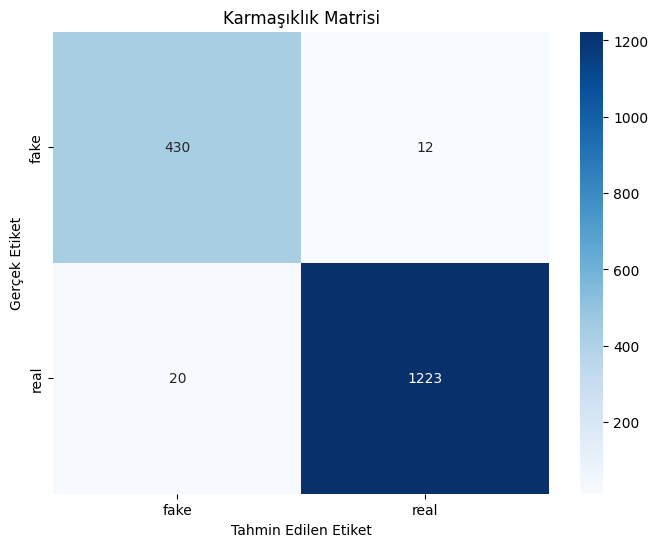

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Validasyon setindeki tüm gerçek etiketleri ve modelin tahminlerini toplayalım
y_true = []
y_pred = []

for images, labels in validation_dataset:
    y_true.extend(labels.numpy().flatten())
    predictions = model.predict(images, verbose=0)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    y_pred.extend(predicted_classes)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- HATANIN ÇÖZÜLDÜĞÜ YER ---
# Hata veren 'validation_dataset.class_names' satırını kaldırıyoruz.
# Yerine, klasör isimlerinin alfabetik sırasına göre listeyi manuel oluşturuyoruz.
# 'fake' klasörü 0, 'real' klasörü 1 olarak etiketlenir.
class_names = ['fake', 'real']
print(f"Sınıf dizini: {class_names}")

# 2. Sınıflandırma Raporunu Yazdır
print("\n--- Sınıflandırma Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Karmaşıklık Matrisini (Confusion Matrix) Oluştur ve Görselleştir
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Etiket')
plt.ylabel('Gerçek Etiket')
plt.title('Karmaşıklık Matrisi')
plt.show()

In [ ]:
import tensorflow as tf
import cv2 # <- Missing import added here
import numpy as np # numpy import'u eklendi
import os # os import'u eklendi

# Yüz tespiti için
from mtcnn.mtcnn import MTCNN

# Modeli yüklemek için IMG_SIZE değişkenine ihtiyaç var
IMG_SIZE = (128, 128) # IMG_SIZE burada tanımlandı

# ... hücrenin geri kalanı aynı ...
# --- ADIM 6: Değerlendirme ve Tek Video ile Test (DÜZELTİLMİŞ) ---

# --- MODELİN KARNESİNİ ÇIKARMA ---
# Bu bölümde Sınıflandırma Raporu ve Karmaşıklık Matrisi kodlarınızı çalıştırabilirsiniz.
# Bu rapor, hocanızın istediği F1, accuracy, recall, precision metriklerini verecektir.
# Lütfen bu kodların doğru çalıştığından emin olun.

# --- TEK VİDEO TAHMİN FONKSİYONU ---

# Kaydettiğimiz yeni modeli yükleyelim
saved_model_path = '/content/drive/MyDrive/Deepfake_Projesi/custom_cnn_deepfake_detector.h5'
inference_model = tf.keras.models.load_model(saved_model_path)
detector = MTCNN() # Yüz dedektörünü tekrar tanımla (gerekirse)

def predict_single_video(video_path, threshold=0.5):
    """
    Tek bir video dosyasını analiz eder ve deepfake olup olmadığına karar verir.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Hata: Video açılamadı -> {video_path}")
        return

    face_predictions = []
    frame_count = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Her 15 karede bir işlem yap (hızlandırmak için)
        if frame_count % 15 == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = detector.detect_faces(frame_rgb)

            if results:
                for result in results: # Karedeki tüm yüzler için
                    x, y, w, h = result['box']
                    x, y = max(0, x), max(0, y)
                    face = frame[y:y+h, x:x+w]

                    # BURASI HATA ALDIĞINIZ VE ARTIK DOĞRU YERDE OLAN BLOK
                    if face.size > 0:
                        # DİKKAT: MODELİMİZİN BEKLEDİĞİ ÖN İŞLEME
                        resized_face = cv2.resize(face, IMG_SIZE)

                        # Artık özel preprocess_input YOK! Sadece [0,1] aralığına normalizasyon var.
                        normalized_face = resized_face / 255.0

                        input_face = np.expand_dims(normalized_face, axis=0)

                        # Tahmin yap
                        prediction = inference_model.predict(input_face, verbose=0)[0][0]
                        face_predictions.append(prediction)

        frame_count += 1

    cap.release()

    if not face_predictions:
        print("Videoda hiç yüz tespit edilemedi.")
        return

    avg_prediction = np.mean(face_predictions)

    print(f"\nVideo: {os.path.basename(video_path)}")
    print(f"Ortalama Güven Skoru (1'e yakınsa REAL): {avg_prediction:.4f}")
    if avg_prediction > threshold:
        print(f"SONUÇ: Bu video büyük ihtimalle GERÇEK (REAL).")
    else:
        print(f"SONUÇ: Bu video büyük ihtimalle SAHTE (DEEPFAKE).")

# --- KULLANIM ---
# Test videolarının eğitimde KULLANILMADIĞINDAN emin olun.
test_real_video = '/content/drive/MyDrive/Deepfake_Projesi/datasets/FaceForensics++_C23/original/594.mp4'
test_fake_video = '/content/drive/MyDrive/Deepfake_Projesi/datasets/FaceForensics++_C23/Deepfakes/226_491.mp4'

print("--- Tek Video Testi Başlatılıyor ---")
predict_single_video(test_real_video)
predict_single_video(test_fake_video)


--- Tek Video Testi Başlatılıyor ---

Video: 594.mp4
Ortalama Güven Skoru (1'e yakınsa REAL): 1.0000
SONUÇ: Bu video büyük ihtimalle GERÇEK (REAL).

Video: 226_491.mp4
Ortalama Güven Skoru (1'e yakınsa REAL): 1.0000
SONUÇ: Bu video büyük ihtimalle GERÇEK (REAL).


Modelin validasyon seti üzerindeki performansı ölçülüyor...


Değerlendirme:   0%|          | 0/53 [00:00<?, ?it/s]


--- Model Performans Raporu ---
              precision    recall  f1-score   support

        fake       0.95      0.97      0.96       442
        real       0.99      0.98      0.99      1243

    accuracy                           0.98      1685
   macro avg       0.97      0.98      0.97      1685
weighted avg       0.98      0.98      0.98      1685


--- Karmaşıklık Matrisi ---


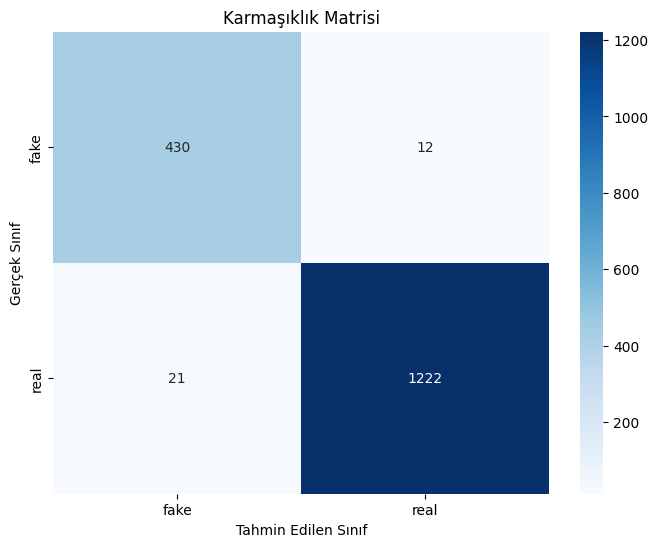

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm # İlerleme çubuğu için

# 1. Gerekli listeleri boş olarak başlatalım
y_true = [] # Gerçek etiketler için
y_pred = [] # Modelin tahminleri için

# 2. Validasyon seti üzerinde döngüye girerek tüm tahminleri toplayalım
# tqdm ile işlemin ne kadar sürdüğünü görmek faydalıdır.
print("Modelin validasyon seti üzerindeki performansı ölçülüyor...")
for images, labels in tqdm(validation_dataset, desc="Değerlendirme"):
    # Gerçek etiketleri listeye ekle
    y_true.extend(labels.numpy().flatten())

    # Modelin tahminlerini al.
    # ÖNEMLİ: Burada herhangi bir ön işleme yapmıyoruz, çünkü veri seti zaten
    # tf.data pipeline'ı tarafından doğru formatta sunuluyor.
    predictions = model.predict(images, verbose=0)

    # Sigmoid çıktısını (0 ile 1 arası olasılık) sınıfa (0 veya 1) dönüştür.
    # Eşik değerimiz 0.5.
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    y_pred.extend(predicted_classes)

# 3. Sonuçları NumPy array'e çevirelim
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 4. Sınıf isimlerini tanımlayalım
# image_dataset_from_directory klasörleri alfabetik olarak sıralar: 'fake' (0), 'real' (1)
class_names = ['fake', 'real']

# 5. Model Performans Raporunu Yazdıralım
# Bu rapor hocanızın istediği precision, recall, f1-score ve accuracy metriklerini içerir.
print("\n--- Model Performans Raporu ---")
print(classification_report(y_true, y_pred, target_names=class_names))

# 6. Karmaşıklık Matrisini (Confusion Matrix) Görselleştirelim
# Bu matris, modelin hangi sınıfları birbiriyle karıştırdığını net bir şekilde gösterir.
print("\n--- Karmaşıklık Matrisi ---")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Tahmin Edilen Sınıf')
plt.ylabel('Gerçek Sınıf')
plt.title('Karmaşıklık Matrisi')
plt.show()

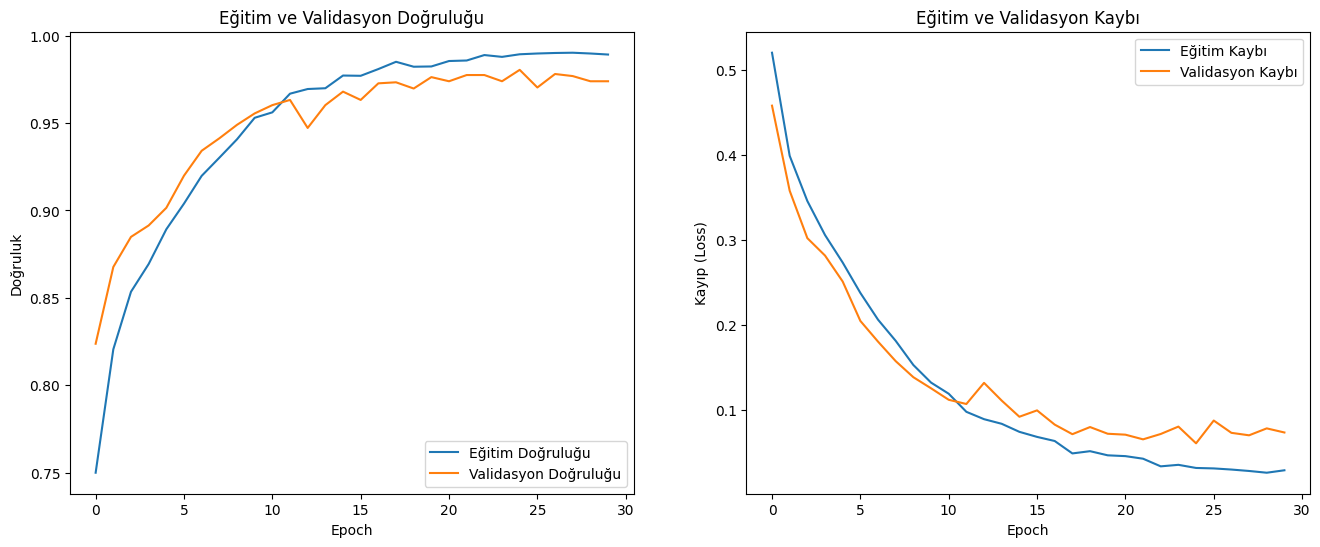

In [ ]:
# --- EĞİTİM SÜRECİNİ GÖRSELLEŞTİRME ---

# history objesi model.fit() komutundan gelmelidir.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu')
plt.plot(epochs_range, val_acc, label='Validasyon Doğruluğu')
plt.legend(loc='lower right')
plt.title('Eğitim ve Validasyon Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Validasyon Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Validasyon Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp (Loss)')

plt.show()

ROC için tahminler alınıyor:   0%|          | 0/53 [00:00<?, ?it/s]

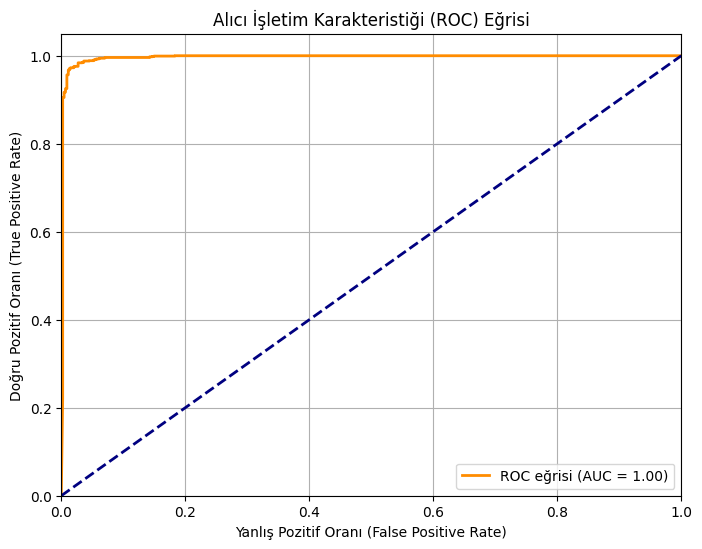

In [ ]:
# --- ROC EĞRİSİ VE AUC SKORU ---
from sklearn.metrics import roc_curve, auc

# Modelin olasılık tahminlerini almamız gerekiyor (0 veya 1 değil)
y_pred_probs = []
y_true_roc = []

for images, labels in tqdm(validation_dataset, desc="ROC için tahminler alınıyor"):
    y_true_roc.extend(labels.numpy().flatten())
    # predict() komutundan gelen ham olasılık değerlerini alıyoruz
    predictions = model.predict(images, verbose=0).flatten()
    y_pred_probs.extend(predictions)

y_true_roc = np.array(y_true_roc)
y_pred_probs = np.array(y_pred_probs)

# ROC eğrisi için değerleri hesapla
fpr, tpr, thresholds = roc_curve(y_true_roc, y_pred_probs)
# AUC skorunu hesapla
roc_auc = auc(fpr, tpr)

# Eğriyi çizdir
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC eğrisi (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Rastgele tahmin çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('Alıcı İşletim Karakteristiği (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
import os
import glob
import shutil

# Proje Yolları
DRIVE_BASE_PATH = "/content/drive/MyDrive/Deepfake_Projesi"
RAW_DATA_PATH = os.path.join(DRIVE_BASE_PATH, "datasets", "FaceForensics++_C23")
TEST_DATA_PATH = os.path.join(DRIVE_BASE_PATH, "final_test_data_25_25") # Anlaşılır olması için yeni bir isim verdim

# Önceki test verisi varsa diye temizleyelim
if os.path.exists(TEST_DATA_PATH):
    shutil.rmtree(TEST_DATA_PATH)
    print(f"Eski '{TEST_DATA_PATH}' klasörü temizlendi.")

# Test klasörlerini yeniden oluşturalım
os.makedirs(os.path.join(TEST_DATA_PATH, "real"), exist_ok=True)
os.makedirs(os.path.join(TEST_DATA_PATH, "fake"), exist_ok=True)
print(f"Yeni '{TEST_DATA_PATH}' klasörü oluşturuldu.")

# ==============================================================================
# 1. 25 ADET GERÇEK VİDEO AL
# ==============================================================================
# Eğitimde ilk 250'yi kullanmıştık. Şimdi 250'den sonraki 25 videoyu alıyoruz.
real_videos_to_test = sorted(glob.glob(os.path.join(RAW_DATA_PATH, "original", "*.mp4")))[250:275]

for video in real_videos_to_test:
    shutil.copy(video, os.path.join(TEST_DATA_PATH, "real"))

print(f"-> {len(real_videos_to_test)} adet GERÇEK video 'real' klasörüne başarıyla kopyalandı.")


# ==============================================================================
# 2. 25 ADET SAHTE VİDEO AL (SADECE DEEPFAKES KLASÖRÜNDEN)
# ==============================================================================
# Eğitimde ilk 50'yi kullanmıştık. Şimdi 50'den sonraki 25 videoyu alıyoruz.
fake_videos_to_test = sorted(glob.glob(os.path.join(RAW_DATA_PATH, "Deepfakes", "*.mp4")))[50:75]

for video in fake_videos_to_test:
    shutil.copy(video, os.path.join(TEST_DATA_PATH, "fake"))

print(f"-> {len(fake_videos_to_test)} adet SAHTE video 'fake' klasörüne başarıyla kopyalandı.")

print("\nİstediğin gibi, 25 gerçek ve 25 sahte videodan oluşan test seti hazır!")

Eski '/content/drive/MyDrive/Deepfake_Projesi/final_test_data_25_25' klasörü temizlendi.
Yeni '/content/drive/MyDrive/Deepfake_Projesi/final_test_data_25_25' klasörü oluşturuldu.
-> 25 adet GERÇEK video 'real' klasörüne başarıyla kopyalandı.
-> 25 adet SAHTE video 'fake' klasörüne başarıyla kopyalandı.

İstediğin gibi, 25 gerçek ve 25 sahte videodan oluşan test seti hazır!


In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mtcnn.mtcnn import MTCNN

# ==========================================================
# AYARLAR VE MODEL YÜKLEME
# ==========================================================
MODEL_PATH = "/content/drive/MyDrive/Deepfake_Projesi/deep_cnn_detector_best_model.h5"
TEST_DATA_PATH = "/content/drive/MyDrive/Deepfake_Projesi/final_test_data_25_25"
IMG_SIZE = (128, 128) # Modelinizi 128x128 ile eğittiğiniz için bu değeri kullanıyoruz.

print("Model ve gerekli araçlar yükleniyor...")
model = tf.keras.models.load_model(MODEL_PATH)
detector = MTCNN()
print("Model ve MTCNN başarıyla yüklendi. Test başlıyor...")

# ==========================================================
# GELİŞTİRİLMİŞ VİDEO TAHMİN FONKSİYONU
# ==========================================================
def predict_single_video_with_mtcnn(video_path, model, input_size):
    """
    MTCNN ile yüz tespiti yaparak tek bir videonun REAL/FAKE tahminini yapar.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return "HATA"

    face_predictions = []
    frame_count = 0

    # Videonun ilk 30 karesini analiz edelim (hız için)
    while frame_count < 30:
        ret, frame = cap.read()
        if not ret:
            break

        # MTCNN BGR yerine RGB formatında resim bekler
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(frame_rgb)

        if results:
            # Sadece ilk ve en belirgin yüzü alalım
            x, y, w, h = results[0]['box']
            x, y = max(0, x), max(0, y)
            face = frame[y:y+h, x:x+w]

            if face.size > 0:
                # Modeli beslemek için doğru ön işleme
                resized_face = cv2.resize(face, input_size)
                normalized_face = resized_face / 255.0
                input_face = np.expand_dims(normalized_face, axis=0)

                prediction = model.predict(input_face, verbose=0)[0][0]
                face_predictions.append(prediction)

        frame_count += 1
    cap.release()

    if not face_predictions:
        return "Yüz Bulunamadı"

    # Tüm karelerden gelen tahminlerin ortalamasını alalım
    avg_prediction = np.mean(face_predictions)

    # >>>>>>>> KRİTİK HATA DÜZELTMESİ BURADA! <<<<<<<<<<
    # Modelimiz 1'e yakınsa REAL, 0'a yakınsa FAKE tahmin eder.
    return "REAL" if avg_prediction > 0.5 else "FAKE"

# ==========================================================
# ANA TEST DÖNGÜSÜ VE SONUÇLARI GÖSTERME
# ==========================================================
all_videos = glob.glob(os.path.join(TEST_DATA_PATH, "**", "*.mp4"), recursive=True)
true_labels = []
predicted_labels = []

for video_path in tqdm(all_videos, desc="Test Videoları Değerlendiriliyor"):
    # Videonun bulunduğu klasör ismine göre gerçek etiketi belirle
    ground_truth = "REAL" if "real" in os.path.dirname(video_path).lower() else "FAKE"

    # Tahmini yap
    prediction = predict_single_video_with_mtcnn(video_path, model, IMG_SIZE)

    if prediction in ["REAL", "FAKE"]:
        true_labels.append(ground_truth)
        predicted_labels.append(prediction)

# Sonuçları hesapla ve göster
if len(true_labels) > 0:
    accuracy = accuracy_score(true_labels, predicted_labels)
    # 'FAKE' sınıfı için metrikleri hesapla
    precision_fake = precision_score(true_labels, predicted_labels, pos_label='FAKE', zero_division=0)
    recall_fake = recall_score(true_labels, predicted_labels, pos_label='FAKE', zero_division=0)
    f1_fake = f1_score(true_labels, predicted_labels, pos_label='FAKE', zero_division=0)

    conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=["REAL", "FAKE"])

    print("\n\n" + "="*40)
    print("      PERFORMANS ANALİZİ SONUÇLARI")
    print("="*40)
    print(f"Toplam Test Edilen Video Sayısı: {len(true_labels)}")
    print(f"Doğruluk (Accuracy):             {accuracy * 100:.2f}%")
    print("-" * 40)
    print(" 'FAKE' Sınıfı için Detaylı Metrikler:")
    print(f"   - Hassasiyet (Precision):     {precision_fake * 100:.2f}%")
    print(f"   - Duyarlılık (Recall):        {recall_fake * 100:.2f}%")
    print(f"   - F1 Skoru:                   {f1_fake:.2f}")
    print("-" * 40)
    print("Karışıklık Matrisi (Confusion Matrix):")
    print("          Tahmin: REAL | Tahmin: FAKE")
    print(f"Gerçek: REAL | {conf_matrix[0][0]:<11} | {conf_matrix[0][1]}")
    print(f"Gerçek: FAKE | {conf_matrix[1][0]:<11} | {conf_matrix[1][1]}")
    print("="*40)
else:
    print("Hiçbir video test edilemedi. Lütfen 'TEST_DATA_PATH' yolunu ve video dosyalarını kontrol edin.")

Model ve gerekli araçlar yükleniyor...


Model ve MTCNN başarıyla yüklendi. Test başlıyor...


Test Videoları Değerlendiriliyor:   0%|          | 0/50 [00:00<?, ?it/s]



      PERFORMANS ANALİZİ SONUÇLARI
Toplam Test Edilen Video Sayısı: 50
Doğruluk (Accuracy):             50.00%
----------------------------------------
 'FAKE' Sınıfı için Detaylı Metrikler:
   - Hassasiyet (Precision):     0.00%
   - Duyarlılık (Recall):        0.00%
   - F1 Skoru:                   0.00
----------------------------------------
Karışıklık Matrisi (Confusion Matrix):
          Tahmin: REAL | Tahmin: FAKE
Gerçek: REAL | 25          | 0
Gerçek: FAKE | 25          | 0


In [ ]:
import tensorflow as tf
import numpy as np
import os
import glob
import cv2
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt # Görselleştirme için eklendi

# ==========================================================
# AYARLAR VE MODEL YÜKLEME
# ==========================================================
# Lütfen en son eğittiğiniz modelin adının doğru olduğundan emin olun
MODEL_PATH = "/content/drive/MyDrive/Deepfake_Projesi/deep_cnn_detector_best_model.h5"
IMG_SIZE = (128, 128)

# Ana veri setinin yolu (eğitim videolarını buradan seçeceğiz)
RAW_DATA_PATH = "/content/drive/MyDrive/Deepfake_Projesi/datasets/FaceForensics++_C23"

print("Model ve gerekli araçlar yükleniyor...")
model = tf.keras.models.load_model(MODEL_PATH)
detector = MTCNN()
print("Model ve MTCNN başarıyla yüklendi. Teşhis başlıyor...")


# ==========================================================
# GELİŞTİRİLMİŞ VİDEO TAHMİN FONKSİYONU (Yüz Kaydetme Özelliği Eklendi)
# ==========================================================
def predict_single_video_with_mtcnn(video_path, model, input_size, save_faces=False, save_folder='/content/debug_faces'):
    """
    MTCNN ile yüz tespiti yaparak tek bir videonun REAL/FAKE tahminini yapar.
    Ayrıca istenirse tespit edilen yüzleri diske kaydeder.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return "HATA", None

    # Yüz kaydetme için klasörü oluştur
    if save_faces:
        os.makedirs(save_folder, exist_ok=True)

    face_predictions = []
    frame_count = 0

    while frame_count < 30:
        ret, frame = cap.read()
        if not ret: break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = detector.detect_faces(frame_rgb)

        if results:
            x, y, w, h = results[0]['box']
            x, y = max(0, x), max(0, y)
            face = frame[y:y+h, x:x+w]

            if face.size > 0:
                # Kırpılan yüzü, diske kaydetme (opsiyonel)
                if save_faces:
                    save_path = os.path.join(save_folder, f"{os.path.basename(video_path)}_{frame_count}.jpg")
                    cv2.imwrite(save_path, face)

                # Modeli beslemek için ön işleme
                resized_face = cv2.resize(face, input_size)
                normalized_face = resized_face / 255.0
                input_face = np.expand_dims(normalized_face, axis=0)

                prediction = model.predict(input_face, verbose=0)[0][0]
                face_predictions.append(prediction)

        frame_count += 1
    cap.release()

    if not face_predictions:
        return "Yüz Bulunamadı", None

    avg_prediction = np.mean(face_predictions)
    final_label = "REAL" if avg_prediction > 0.5 else "FAKE"

    return final_label, avg_prediction

# ==========================================================
# ADIM 1: "EĞİTTİĞİ VİDEODAN TEST ET" HİPOTEZİ
# ==========================================================
print("\n" + "="*50)
print("     TEŞHİS AŞAMASI 1: EĞİTİM VERİSİ İLE TEST")
print("="*50)

# Eğitim için kullandığınız videolardan birini seçin.
# Örneğin, eğitimde ilk 250 videoyu kullandıysanız, o aralıktan bir video seçin.
test_real_video_from_train = os.path.join(RAW_DATA_PATH, "original", "005.mp4")
test_fake_video_from_train = os.path.join(RAW_DATA_PATH, "Deepfakes", "000_003.mp4")

# GERÇEK VİDEO TESTİ (EĞİTİM SETİNDEN)
print(f"\n--- Test Edilen Gerçek Video (Eğitimden): {os.path.basename(test_real_video_from_train)} ---")
pred_label, pred_score = predict_single_video_with_mtcnn(test_real_video_from_train, model, IMG_SIZE)
print(f"   Ortalama Güven Skoru (1'e yakınsa REAL): {pred_score:.4f}" if pred_score is not None else "")
print(f"   Modelin Tahmini: {pred_label}")
print(f"   BEKLENEN SONUÇ: REAL -> {'BAŞARILI' if pred_label == 'REAL' else 'BAŞARISIZ'}")


# SAHTE VİDEO TESTİ (EĞİTİM SETİNDEN)
print(f"\n--- Test Edilen Sahte Video (Eğitimden): {os.path.basename(test_fake_video_from_train)} ---")
pred_label, pred_score = predict_single_video_with_mtcnn(test_fake_video_from_train, model, IMG_SIZE, save_faces=True)
print(f"   Ortalama Güven Skoru (1'e yakınsa REAL): {pred_score:.4f}" if pred_score is not None else "")
print(f"   Modelin Tahmini: {pred_label}")
print(f"   BEKLENEN SONUÇ: FAKE -> {'BAŞARILI' if pred_label == 'FAKE' else 'BAŞARISIZ'}")
print("\n(NOT: Sahte videodan kırpılan yüzler incelenmek üzere '/content/debug_faces/' klasörüne kaydedildi.)")


# ==========================================================
# ADIM 2: NORMAL TEST (EĞER ADIM 1 BAŞARILI OLURSA ÇALIŞTIRIN)
# ==========================================================
# Yukarıdaki teşhis testleri "BAŞARILI" sonucunu verirse,
# aşağıdaki kodu çalıştırarak normal test setiniz üzerindeki performansı ölçebilirsiniz.
# Eğer teşhis "BAŞARISIZ" ise, bu bölümü çalıştırmanın bir anlamı yoktur.

# print("\n" + "="*50)
# print("     NORMAL PERFORMANS ANALİZİ")
# print("="*50)
#
# TEST_DATA_PATH = "/content/drive/MyDrive/Deepfake_Projesi/final_test_data_25_25"
# all_videos = glob.glob(os.path.join(TEST_DATA_PATH, "**", "*.mp4"), recursive=True)
# true_labels, predicted_labels = [], []
#
# for video_path in tqdm(all_videos, desc="Test Videoları Değerlendiriliyor"):
#     ground_truth = "REAL" if "real" in os.path.dirname(video_path).lower() else "FAKE"
#     prediction, score = predict_single_video_with_mtcnn(video_path, model, IMG_SIZE)
#     if prediction in ["REAL", "FAKE"]:
#         true_labels.append(ground_truth)
#         predicted_labels.append(prediction)
#
# # ... (Sonuçları gösterme kodunun geri kalanı) ...

Model ve gerekli araçlar yükleniyor...


Model ve MTCNN başarıyla yüklendi. Teşhis başlıyor...

     TEŞHİS AŞAMASI 1: EĞİTİM VERİSİ İLE TEST

--- Test Edilen Gerçek Video (Eğitimden): 005.mp4 ---
   Ortalama Güven Skoru (1'e yakınsa REAL): 0.9999
   Modelin Tahmini: REAL
   BEKLENEN SONUÇ: REAL -> BAŞARILI

--- Test Edilen Sahte Video (Eğitimden): 000_003.mp4 ---
   Ortalama Güven Skoru (1'e yakınsa REAL): 0.9999
   Modelin Tahmini: REAL
   BEKLENEN SONUÇ: FAKE -> BAŞARISIZ

(NOT: Sahte videodan kırpılan yüzler incelenmek üzere '/content/debug_faces/' klasörüne kaydedildi.)
